<H1>Необходимо предсказать верхнюю границу заработной платы (salary_to) для вакансии</H1>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import xlrd
from itertools import chain
pd.set_option('display.max_colwidth', None)

Считываем данные для обучения:

In [2]:
df = pd.read_csv('X_train.csv', parse_dates=['published_at', 'created_at'])

Считываем значения salary_to для данных для обучения и мерджим с предыдущей таблицей

In [3]:
df1 = pd.read_csv('y_train.csv')
df = df.set_index('id').join(df1.set_index('id'))

<H1>Исследование данных / Data exploration</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   created_at                27934 non-null  datetime64[ns, UTC]
 8   employer_name             27934 non-null  object             
 9   description               27933 non-null  object             
 10  area_id                   27934 non-null  int64              
 11  area_name       

Можно увидеть, что есть пустые значения у <i>salary_from</i>. Есть пустые значения у <i>salary_gross</i>, который должен быть из описания bool, а импортировался как object. И ещё отсутствует одно значение в <i>description</i>.

In [5]:
pd.options.display.max_rows = 13
df.describe(include='O')

,name,salary_currency,salary_gross,employer_name,description,area_name
count,27934,27934,27786,27934,27933,27934
unique,16395,1,2,13318,23681,156
top,Менеджер по продажам,RUR,False,Пятёрочка,"<p><strong>Обязанности:</strong></p><ul><li>Обслуживание покупателей на кассе (наличный и безналичный расчет)</li><li>Выкладка товара в зале</li><li>Отслеживание сроков годности товара</li><li>Проверка наличия ценников</li><li>Консультация покупателей в зале</li></ul><p><strong>Требования:</strong></p><ul><li>Ответственность, дисциплинированность, внимательность</li></ul><p><strong>Условия:</strong></p><ul><li>График работы 5/2, 2/2, возможен неполный рабочий день, неполная рабочая неделя</li><li>Возможность подработки (работа по совместительству)</li><li>Социальные гарантии, оплата отпусков и больничных листов</li><li>Работа рядом с домом</li><li>Скидки в магазинах сети</li><li>Фирменная спецодежда</li><li>Возможность профессионального и карьерного роста, корпоративное обучение</li><li>Корпоративные мероприятия и конкурсы</li></ul>",Москва
freq,337,27934,18726,927,624,20512


<H1>Даты</H1>

Посмотрим корреляцию <i>published_at</i> и <i>created_at</i>.

In [6]:
#(df['published_at']==df['created_at']).value_counts()
df[['published_at', 'created_at']].corr().style.background_gradient()

,published_at,created_at
published_at,1.000000,1.000000
created_at,1.000000,1.000000


Эти столбцы полностью совпадают, один из них можно удалить.

In [7]:
df = df.drop(columns=['created_at'])

Разберемся с датами в <i>published_at</i>. Заменим даты на разницу между концом 2022 года (за который собирался dataset) и датой в <i>published_at</i>:

In [8]:
df['published_at_diff'] = df['published_at'].map(lambda x: datetime.timestamp(datetime(2023, 1, 1)) - x.timestamp())

Теперь столбец <i>published_at</i> можно удалить.

In [9]:
df = df.drop(columns=['published_at'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               23902 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


<H1>Количественные / Quantitative</H1>

В salary_from есть пустые значения. Поместим туда самое частое значение:

In [11]:
#df_filtered = df.dropna(subset = ['salary_from'])
df.salary_from.fillna(df.salary_from.mode()[0], inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


Посмотрим на распределение всех числовых величин:

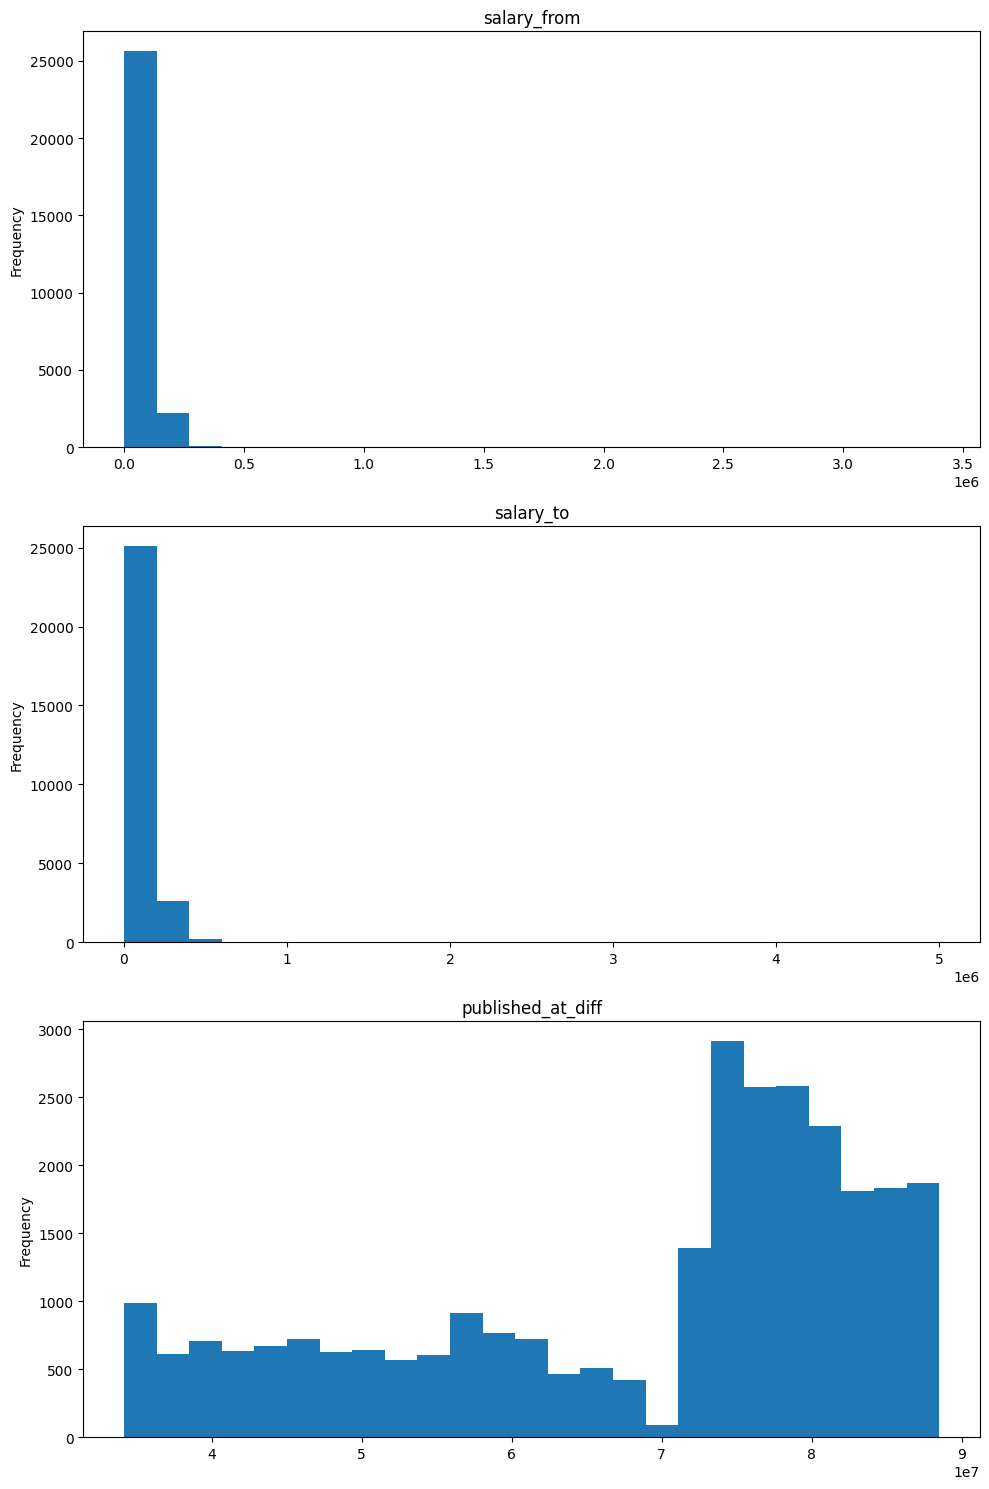

In [13]:
import matplotlib.pyplot as plt
df_numeric = df[['salary_from', 'salary_to', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric.columns):
    df_numeric[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

Нормализуем <i>publised_at_diff</i>:

In [14]:
df["published_at_diff"] = df["published_at_diff"] / 1e7

<H1>Категориальные / Category</H1>

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


<H2>salary_gross</H2>

Для <i>salary_gross</i> нужно заполнить пропуски False и преобразовать из типа object в тип bool: 

In [16]:
df.salary_gross.fillna(False, inplace = True) 
df['salary_gross'] = df['salary_gross'].astype(bool)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27934 non-null  bool   
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 3.2+ MB


<H2>salary_currency</H2>

Посмотрим, сколько уникальных значений есть в <i>salary_currency</i>.

In [18]:
df['salary_currency'].value_counts()

salary_currency
RUR    27934
Name: count, dtype: int64

У всех строк одна и та же валюта, этот столбец можно удалить.

In [19]:
df = df.drop(columns=['salary_currency'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27933 non-null  object 
 7   area_id                   27934 non-null  int64  
 8   area_name                 27934 non-null  object 
 9   salary_to                 27934 non-null  float64
 10  published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 3.0+ MB


<H2>area_name и area_id</H2>

Разберемся с <i>area_id</i> и <i>area_name</i>.

In [21]:
map_id_to_name = {}
for idx in df.index:
    if df['area_id'][idx] in map_id_to_name:
        map_id_to_name[df['area_id'][idx]].add((df['area_name'][idx], ))
    else:
        map_id_to_name[df['area_id'][idx]] = set(((df['area_name'][idx], ), ))
map_id_to_name

{1: {('Москва',)},
 2: {('Санкт-Петербург',)},
 72: {('Пермь',)},
 4: {('Новосибирск',)},
 78: {('Самара',)},
 26: {('Воронеж',)},
 35: {('Иркутск',)},
 3: {('Екатеринбург',)},
 77: {('Рязань',)},
 24: {('Волгоград',)},
 76: {('Ростов-на-Дону',)},
 54: {('Красноярск',)},
 53: {('Краснодар',)},
 66: {('Нижний Новгород',)},
 96: {('Ижевск',)},
 247: {('Дзержинск (Нижегородская область)',)},
 41: {('Калининград',)},
 90: {('Томск',)},
 98: {('Ульяновск',)},
 130: {('Севастополь',)},
 68: {('Омск',)},
 43: {('Калуга',)},
 99: {('Уфа',)},
 22: {('Владивосток',)},
 49: {('Киров (Кировская область)',)},
 88: {('Казань',)},
 32: {('Иваново (Ивановская область)',)},
 1002: {('Минск',)},
 44: {('Петропавловск-Камчатский',)},
 112: {('Ярославль',)},
 160: {('Алматы',)},
 104: {('Челябинск',)},
 2734: {('Иннополис',)},
 92: {('Тула',)},
 71: {('Пенза',)},
 2088: {('Зеленоград',)},
 2059: {('Павловский Посад',)},
 159: {('Нур-Султан',)},
 83: {('Смоленск',)},
 79: {('Саратов',)},
 89: {('Тверь',)},

Удалим <i>area_id</i>, и посмотрим на то, сколько раз встречается тот или иной город.

In [22]:
df = df.drop(columns=['area_id'])

In [23]:
df['area_name'].value_counts()

area_name
Москва                         20512
Санкт-Петербург                 5393
Новосибирск                      201
Краснодар                        178
Екатеринбург                     158
                               ...  
Каменск-Шахтинский                 1
Стерлитамак                        1
Турция                             1
Донецк (Ростовская область)        1
Курган                             1
Name: count, Length: 156, dtype: int64

Выделим несколько часто встречающихся городов, остальные заменим Other:

In [24]:
df.loc[df["area_name"].value_counts()[df["area_name"]].values < 150, "area_name"] = "Other"
df['area_name'].value_counts()

area_name
Москва             20512
Санкт-Петербург     5393
Other               1339
Новосибирск          201
Краснодар            178
Екатеринбург         158
Казань               153
Name: count, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27933 non-null  object 
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(3), object(4)
memory usage: 2.8+ MB


<H2>description</H2>

В колонке <i>description</i> есть много информации, написанной в виде HTML страницы. Сначала преобразуем к нижнему регистру

In [26]:
import re
df['description'] = pd.Series(df['description'],dtype=pd.StringDtype())
df.description = df.description.apply(lambda x: str(x).lower())

Выделим из описаний требуемый опыт работы

In [27]:
def manage_desc_exp(string):
    #print(string)
    pattern = r'опыт[а-яА-ЯёЁ ]+[0-9]+[-лгм ]+[а-яА-ЯеЁ ]+[;<]'
    year = 0
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        prev_ch = ' '
        for ch in match:
            if ch.isnumeric() and (first_numeric_found or prev_ch == ' '):
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                prev_ch = ch
                pass
            else:
                if first_numeric_found:
                    break
            prev_ch = ch
        try:
            cur_year = int(number)
        except ValueError:
            cur_year = 0
        if 'мес' in match:
            cur_year /= 12
        if cur_year > year and cur_year <= 10:
            year = cur_year
    return 1 if year == 0 else year

In [28]:
df['description_exp'] = df.description.map(manage_desc_exp)

In [29]:
df['description_exp'].value_counts()

description_exp
1.000000    26641
3.000000      582
2.000000      487
5.000000      105
0.500000       63
            ...  
9.000000        2
0.166667        1
0.333333        1
0.416667        1
0.666667        1
Name: count, Length: 15, dtype: int64

Далее, удалим HTML теги у другие ненужные символы

In [30]:
df.description = df.description.apply(lambda x: re.sub(r'<[^>]+>', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

In [31]:
df.description = df.description.apply(lambda x: re.sub(r'[^а-яА-Я0-9a-zA-ZёЁ.-]', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

В некоторых есть упоминание з/п в формате "<число> руб." или "<число> руб./час" или "<число> тыс. руб.". Попробуем их выцепить. Если таковой нет, сделаем её равной 0. Также сделаем равной 0 зарплаты, которые получились меньше 1000. Такое могло произойти, если извлеченная зарплата была не той по смыслу, или была какая-то другая цена.

In [32]:
def manage_desc(string):
    #print(string)
    pattern = r'[0-9][0-9., ]+[0-9 ](тыс)?руб.?\/?[а-яА-Я ]*([0-9 ]+час)?(час)?(мес)?(день)?'
    max_salary = -1
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        for ch in match:
            if ch.isnumeric():
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                pass
            else:
                if first_numeric_found:
                    break
        salary = int(number)
        if 'сут' in match or 'день' in match:
            salary *= 20
        elif 'час' in match:
            salary *= 160

        if 'тыс' in match or 'т.' in match:
            salary *= 1000
        
        if max_salary == -1 or salary > max_salary:
            max_salary = salary
    
    if max_salary < 1000:
        return pd.NA
    else:
        return max_salary

#manage_desc(df['description'][23187])

In [33]:
df['description_salary'] = df.description.map(manage_desc)
df['description_salary'].value_counts()

description_salary
40000           311
50000           288
60000           271
30000           234
100000          221
               ... 
15200             1
150000180000      1
2170              1
155000            1
32000000          1
Name: count, Length: 438, dtype: int64

Заполним пустые значения значениями из <i>salary_from</i>

In [34]:
df['description_salary'].fillna(df['salary_from'], inplace = True) 

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27934 non-null  object 
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  float64
 10  description_exp           27934 non-null  float64
 11  description_salary        27934 non-null  object 
dtypes: bool(3), float64(4), object(5)
memory usage: 3.2+ MB


In [36]:
df['description_salary'] = pd.Series(df['description_salary'],dtype='float64')

Теперь векторизуем информацию из описания

In [37]:
df['description'] = df['description'].apply(lambda x: re.sub(r'[^а-яА-Я0-9a-zA-ZёЁ]', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

In [38]:
## remove tabulation and punctuation
df['description'] = df['description'].map(lambda x: re.sub(r'[^\w\s]', ' ', x)) #str.replace(,' '))
## digits
df['description'] = df['description'].map(lambda x: re.sub(r'\d+', ' ', x))#.str.replace(, '')

In [39]:
df['description'].fillna('nd', inplace = True)

In [40]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
from textblob import Word
## lemmatization
df['description'] = df['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [42]:
from stop_words import get_stop_words

stop_words = get_stop_words('russian')
stop_words1 = get_stop_words('english')

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [44]:
vectorizer = TfidfVectorizer(input='content', encoding='utf-8', 
                             decode_error='strict', strip_accents=None, lowercase=True,
                             preprocessor=None, tokenizer=lambda x: x.split(), analyzer='word',
                             stop_words=stop_words+stop_words1, min_df=6, dtype=np.float32, max_features=512,
                             token_pattern=r'(?u)\b\w\w\w\w+\b')

In [45]:
df_desc_parsed = vectorizer.fit_transform(df['description'])

In [46]:
df_desc_parsed

<27934x512 sparse matrix of type '<class 'numpy.float32'>'
	with 1203648 stored elements in Compressed Sparse Row format>

In [47]:
df = df.drop(columns=['description'])

<H2>employer_name</H2>

Далее посмотрим на employer_name

In [48]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    927
Пятерочка                    669
Перекресток                  324
Билайн                       261
JCat.ru                       70
                            ... 
Торговая группа ПТК            1
LTG Consulting                 1
ExMail                         1
Албаков Руслан Борисович       1
Балтик Граунд Сервисес РУ      1
Name: count, Length: 13318, dtype: int64

Во первых, можно увидеть два разных написания "Пятерочка", возможно есть другие названия, которые отличаются в одном символе. Посмотрим на верхние 3 значения.

In [49]:
import builtins


def near_equal(string, pattern):
    string1 = string.strip()
    string2 = pattern.strip()
    max_len = max(len(string1), len(string2))
    min_len = builtins.min(len(string1), len(string2))
    score = 0
    for i in range(0, min_len):
        if (string1[i] == string2[i]):
            score += 1

    return score / max_len

In [50]:
df['employer_name'] = df['employer_name'].apply(lambda x: x.lower())
df['employer_name'] = df['employer_name'].apply(lambda x: x.strip())

In [51]:
df['employer_name'].value_counts()

employer_name
пятёрочка                    927
пятерочка                    669
перекресток                  324
билайн                       261
jcat.ru                       70
                            ... 
торговая группа птк            1
ltg consulting                 1
exmail                         1
албаков руслан борисович       1
балтик граунд сервисес ру      1
Name: count, Length: 13236, dtype: int64

In [52]:
df.employer_name = df.employer_name.apply(lambda x: "пятёрочка" if near_equal(x, 'пятёрочка') > 0.75 else x)
df.employer_name = df.employer_name.apply(lambda x: "перекресток" if near_equal(x, 'перекресток') > 0.75 else x)
df.employer_name = df.employer_name.apply(lambda x: "билайн" if near_equal(x, 'билайн') > 0.75 else x)

In [53]:
df['employer_name'].value_counts()

employer_name
пятёрочка                    1596
перекресток                   324
билайн                        262
jcat.ru                        70
skyeng                         63
                             ... 
dgl group                       1
компания нк-сити                1
скриптогенератор                1
бандура дарья алексеевна        1
балтик граунд сервисес ру       1
Name: count, Length: 13234, dtype: int64

В списке <i>employer_name</i> есть ИП, написанные как ФИО. Заменим их всех на категорию "personname"

In [54]:
df['employer_name'] = df['employer_name'].apply(lambda x: "personname" if x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') else x) #or x.startswith('ип') or '(ип ' in x)
df['employer_name'].value_counts()

employer_name
personname                        1662
пятёрочка                         1596
перекресток                        324
билайн                             262
jcat.ru                             70
                                  ... 
шеф remont                           1
патронаж-сити                        1
агрегатор страхования блайсико       1
пластполимер-т                       1
балтик граунд сервисес ру            1
Name: count, Length: 12055, dtype: int64

Векторизириуем имена

In [55]:
vectorizer_empl = TfidfVectorizer(input='content', encoding='utf-8', 
                             decode_error='strict', strip_accents=None, lowercase=True,
                             preprocessor=None, tokenizer=lambda x: x.split(), analyzer='word',
                             stop_words=stop_words+stop_words1, min_df=6, dtype=np.float32, max_features=50,
                             token_pattern=r'(?u)\b\w\w\w\w+\b')

In [56]:
df_empl_parsed = vectorizer_empl.fit_transform(df['employer_name'])

In [57]:
df = df.drop(columns=['employer_name'])

<H2>name</H2>

Теперь рассмотрим последний столбец: <i>name</i>

In [58]:
df['name'].value_counts()

name
Менеджер по продажам                                   337
Менеджер по работе с клиентами                         201
Юрист                                                  162
Помощник юриста                                        149
Аналитик                                               145
                                                      ... 
Бизнес-аналитик(Внедренец/ Ведущий бизнес-аналитик)      1
Руководитель департамента коммерческой недвижимости      1
Логист- оператор / Грузчик (ТРК Европолис)               1
User Acquisition Manager                                 1
Копирайтер / контент менеджер                            1
Name: count, Length: 16395, dtype: int64

Сначала преобразуем всё к нижнему регистру:

In [59]:
df['name'] = df['name'].apply(lambda x: x.lower())
df['name'] = df['name'].apply(lambda x: x.strip())
df['name'].value_counts()

name
менеджер по продажам                                   340
менеджер по работе с клиентами                         202
юрист                                                  162
уборщица/уборщик                                       150
помощник юриста                                        149
                                                      ... 
руководитель департамента коммерческой недвижимости      1
логист- оператор / грузчик (трк европолис)               1
user acquisition manager                                 1
конструктор - технолог корпусной мебели                  1
копирайтер / контент менеджер                            1
Name: count, Length: 16089, dtype: int64

Потом векторизуем

In [60]:
vectorizer_name = TfidfVectorizer(input='content', encoding='utf-8', 
                             decode_error='strict', strip_accents=None, lowercase=True,
                             preprocessor=None, tokenizer=lambda x: x.split(), analyzer='word',
                             stop_words=stop_words+stop_words1, min_df=6, dtype=np.float32, max_features=50,
                             token_pattern=r'(?u)\b\w\w\w\w+\b')

In [61]:
df_name_parsed = vectorizer_name.fit_transform(df['name'])

In [62]:
df = df.drop(columns=['name'])

<H1>One-Hotting</H1>

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   has_test                  27934 non-null  bool   
 1   response_letter_required  27934 non-null  bool   
 2   salary_from               27934 non-null  float64
 3   salary_gross              27934 non-null  bool   
 4   area_name                 27934 non-null  object 
 5   salary_to                 27934 non-null  float64
 6   published_at_diff         27934 non-null  float64
 7   description_exp           27934 non-null  float64
 8   description_salary        27934 non-null  float64
dtypes: bool(3), float64(5), object(1)
memory usage: 2.6+ MB


Сделаем one-hotting для городов

In [64]:
df_one_hoted = df.copy()

#ONE_HOT_COL = ['published_at_diff']
ONE_HOT_COL = ['area_name'] #'name', 'employer_name', 'published_at_diff'

temp = pd.get_dummies(df_one_hoted[ONE_HOT_COL], prefix=ONE_HOT_COL, dtype=bool)

df_one_hoted = pd.concat([temp, df], axis=1)

df_one_hoted.head()

,area_name_Other,area_name_Екатеринбург,area_name_Казань,area_name_Краснодар,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,has_test,response_letter_required,salary_from,salary_gross,area_name,salary_to,published_at_diff,description_exp,description_salary
id,,,,,,,,,,,,,,,,
29083,False,False,False,False,True,False,False,False,False,40000.0,False,Москва,200000.0,8.021610,1.0,40000.0
26052,False,False,False,False,True,False,False,False,False,120000.0,False,Москва,170000.0,7.709255,1.0,120000.0
24055,False,False,False,False,True,False,False,False,False,40000.0,False,Москва,120000.0,8.582645,2.0,40000.0
4408,False,False,False,False,True,False,False,False,False,33500.0,True,Москва,38000.0,7.427419,1.0,33500.0
16856,False,False,False,False,True,False,False,False,True,30000.0,True,Москва,35000.0,4.053419,1.0,30000.0


Удалим столбцы:

In [65]:
df_one_hoted = df_one_hoted.drop(columns=['area_name'])#, 'name', 'employer_name', 'published_at_diff' ])
#df_one_hoted = df_one_hoted.drop(columns=['published_at_diff'])

In [66]:
df_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_name_Other            27934 non-null  bool   
 1   area_name_Екатеринбург     27934 non-null  bool   
 2   area_name_Казань           27934 non-null  bool   
 3   area_name_Краснодар        27934 non-null  bool   
 4   area_name_Москва           27934 non-null  bool   
 5   area_name_Новосибирск      27934 non-null  bool   
 6   area_name_Санкт-Петербург  27934 non-null  bool   
 7   has_test                   27934 non-null  bool   
 8   response_letter_required   27934 non-null  bool   
 9   salary_from                27934 non-null  float64
 10  salary_gross               27934 non-null  bool   
 11  salary_to                  27934 non-null  float64
 12  published_at_diff          27934 non-null  float64
 13  description_exp            27934 non-null  floa

In [67]:
df = df_one_hoted

<H1>Корреляция</H1>

In [68]:
df.corr().style.background_gradient(cmap='coolwarm')

,area_name_Other,area_name_Екатеринбург,area_name_Казань,area_name_Краснодар,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,has_test,response_letter_required,salary_from,salary_gross,salary_to,published_at_diff,description_exp,description_salary
area_name_Other,1.000000,-0.016923,-0.016652,-0.017969,-0.373021,-0.019102,-0.109754,0.012921,0.012041,0.001777,-0.024444,0.009550,-0.230137,0.000900,-0.001343
area_name_Екатеринбург,-0.016923,1.000000,-0.005597,-0.006040,-0.125383,-0.006421,-0.036891,0.015199,-0.005303,0.016281,-0.013506,0.025196,-0.082120,0.000199,-0.000451
area_name_Казань,-0.016652,-0.005597,1.000000,-0.005943,-0.123372,-0.006318,-0.036299,0.006570,0.000116,0.022223,-0.013080,0.015509,-0.087657,0.003307,-0.000444
area_name_Краснодар,-0.017969,-0.006040,-0.005943,1.000000,-0.133130,-0.006818,-0.039171,0.024333,-0.002155,0.020819,-0.009353,0.016071,-0.084795,0.010970,-0.000479
area_name_Москва,-0.373021,-0.125383,-0.123372,-0.133130,1.000000,-0.141528,-0.813153,-0.001626,0.006627,0.060748,0.004193,0.043771,0.046759,0.020818,0.003599
area_name_Новосибирск,-0.019102,-0.006421,-0.006318,-0.006818,-0.141528,1.000000,-0.041642,0.021338,0.000391,0.030771,-0.028221,0.028871,-0.087477,-0.004009,-0.000509
area_name_Санкт-Петербург,-0.109754,-0.036891,-0.036299,-0.039171,-0.813153,-0.041642,1.000000,-0.018765,-0.012597,-0.086979,0.021478,-0.071262,0.140052,-0.025793,-0.002927
has_test,0.012921,0.015199,0.006570,0.024333,-0.001626,0.021338,-0.018765,1.000000,0.074826,0.000321,-0.014268,0.011637,-0.023427,0.015655,-0.000964
response_letter_required,0.012041,-0.005303,0.000116,-0.002155,0.006627,0.000391,-0.012597,0.074826,1.000000,-0.007164,-0.035017,0.007831,-0.029331,0.002189,-0.001204
salary_from,0.001777,0.016281,0.022223,0.020819,0.060748,0.030771,-0.086979,0.000321,-0.007164,1.000000,-0.066327,0.669052,-0.340191,0.082286,-0.002378


In [69]:
#df = df.drop(columns=['description']) #, 'description'
#df['salary_from'] = np.log(df['salary_from'])
#df['description'] = np.exp(df['description'])

In [70]:
#df['salary_from']

<H1>Создание модели</H1>

Преобразуем векторизированные описания, имена работодателей и названия вакансий

In [71]:
DESC_COLS = ['desc_' + str(col) for col in vectorizer.get_feature_names_out()]
df_desc_parsed1 = pd.DataFrame(df_desc_parsed.toarray(), columns=DESC_COLS, index=df.index)
df = df.join(df_desc_parsed1)

In [72]:
EMPL_COLS = ['empl_' + str(col) for col in vectorizer_empl.get_feature_names_out()]
df_empl_parsed1 = pd.DataFrame(df_empl_parsed.toarray(), columns=EMPL_COLS, index=df.index)
df = df.join(df_empl_parsed1)

In [73]:
NAME_COLS = ['name_' + str(col) for col in vectorizer_name.get_feature_names_out()]
df_name_parsed1 = pd.DataFrame(df_name_parsed.toarray(), columns=NAME_COLS, index=df.index)
df = df.join(df_name_parsed1)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Columns: 627 entries, area_name_Other to name_юрист
dtypes: bool(10), float32(612), float64(5)
memory usage: 67.8 MB


Делим на train/test

In [129]:
from sklearn.model_selection import train_test_split


#df_sampled = df.sample(20_000)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='salary_to'), df.salary_to, test_size=0.3, random_state=123456)

In [76]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

<H2>Создаем первую модель: XGBoost с reg:gamma</H2>

In [150]:
%%time
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

params = {
    'objective' : 'reg:gamma',
    #'quantile_alpha' : 0.52,
    #'huber_slope' : 512.0,
    #'tweedie_variance_power' : 1.99,
    #'verbosity' : 2,
    #'eta' : 0.1,
    #'subsample' : 0.5
}

n=100
xg_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    evals=[(dtrain_reg, "training")],
    num_boost_round=n,
)

#xg_model = XGBRegressor()
#xg_model.fit(X_train, y_train)

y_pred_train = xg_model.predict(dtrain_reg)
y_pred_test = xg_model.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

[0]	training-gamma-nloglik:28456.65227
[1]	training-gamma-nloglik:21082.06538
[2]	training-gamma-nloglik:15618.91446
[3]	training-gamma-nloglik:11571.79135
[4]	training-gamma-nloglik:8573.68641
[5]	training-gamma-nloglik:6352.71342
[6]	training-gamma-nloglik:4707.45364
[7]	training-gamma-nloglik:3488.69282
[8]	training-gamma-nloglik:2585.89054
[9]	training-gamma-nloglik:1917.15573
[10]	training-gamma-nloglik:1421.82253
[11]	training-gamma-nloglik:1054.94838
[12]	training-gamma-nloglik:783.23877
[13]	training-gamma-nloglik:582.02893
[14]	training-gamma-nloglik:433.04655
[15]	training-gamma-nloglik:322.75507
[16]	training-gamma-nloglik:241.12638
[17]	training-gamma-nloglik:180.73139
[18]	training-gamma-nloglik:136.06647
[19]	training-gamma-nloglik:103.05431
[20]	training-gamma-nloglik:78.67425
[21]	training-gamma-nloglik:60.68834
[22]	training-gamma-nloglik:47.43846
[23]	training-gamma-nloglik:37.69600
[24]	training-gamma-nloglik:30.55056
[25]	training-gamma-nloglik:25.32710
[26]	trainin

In [77]:
from xgboost import XGBRegressor
import xgboost as xgb

xg_model1 = xgb.Booster()
xg_model1.load_model("xg_model7.bin")

In [78]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [79]:
y_pred_train = xg_model1.predict(dtrain_reg)
y_pred_test = xg_model1.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 11.838376259296822, SMAPE test: 21.718753502096952


In [151]:
params = {
    #'objective' : 'reg:quantileerror',
    #'quantile_alpha' : 0.5,
    #'huber_slope' : 512.0,
    #'tweedie_variance_power' : 1.99,
    #'verbosity' : 2,
    'process_type' : 'default',
    #'eta' : 0.2,
    #'subsample' : 0.5
}

In [152]:
n=600
xg_model1 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=[(dtrain_reg, "training")],
    xgb_model = xg_model
)

y_pred_train = xg_model1.predict(dtrain_reg)
y_pred_test = xg_model1.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

[0]	training-gamma-nloglik:12.30026
[1]	training-gamma-nloglik:12.29989
[2]	training-gamma-nloglik:12.29972
[3]	training-gamma-nloglik:12.29947
[4]	training-gamma-nloglik:12.29929
[5]	training-gamma-nloglik:12.29899
[6]	training-gamma-nloglik:12.29872
[7]	training-gamma-nloglik:12.29851
[8]	training-gamma-nloglik:12.29833
[9]	training-gamma-nloglik:12.29809
[10]	training-gamma-nloglik:12.29784
[11]	training-gamma-nloglik:12.29769
[12]	training-gamma-nloglik:12.29759
[13]	training-gamma-nloglik:12.29740
[14]	training-gamma-nloglik:12.29723
[15]	training-gamma-nloglik:12.29691
[16]	training-gamma-nloglik:12.29610
[17]	training-gamma-nloglik:12.29582
[18]	training-gamma-nloglik:12.29567
[19]	training-gamma-nloglik:12.29558
[20]	training-gamma-nloglik:12.29532
[21]	training-gamma-nloglik:12.29516
[22]	training-gamma-nloglik:12.29501
[23]	training-gamma-nloglik:12.29483
[24]	training-gamma-nloglik:12.29466
[25]	training-gamma-nloglik:12.29445
[26]	training-gamma-nloglik:12.29424
[27]	traini

In [104]:
params = {
    #'objective' : 'reg:quantileerror',
    #'quantile_alpha' : 0.5,
    #'huber_slope' : 512.0,
    #'tweedie_variance_power' : 1.99,
    #'verbosity' : 2,
    'process_type' : 'default',
    #'eta' : 0.2,
    #'subsample' : 0.5
}

In [153]:
n=500
xg_model2 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=[(dtrain_reg, "training")],
    xgb_model = xg_model1
)

y_pred_train = xg_model2.predict(dtrain_reg)
y_pred_test = xg_model2.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

[0]	training-gamma-nloglik:12.26751
[1]	training-gamma-nloglik:12.26750
[2]	training-gamma-nloglik:12.26747
[3]	training-gamma-nloglik:12.26747
[4]	training-gamma-nloglik:12.26747
[5]	training-gamma-nloglik:12.26746
[6]	training-gamma-nloglik:12.26746
[7]	training-gamma-nloglik:12.26746
[8]	training-gamma-nloglik:12.26745
[9]	training-gamma-nloglik:12.26745
[10]	training-gamma-nloglik:12.26744
[11]	training-gamma-nloglik:12.26743
[12]	training-gamma-nloglik:12.26742
[13]	training-gamma-nloglik:12.26741
[14]	training-gamma-nloglik:12.26740
[15]	training-gamma-nloglik:12.26740
[16]	training-gamma-nloglik:12.26738
[17]	training-gamma-nloglik:12.26738
[18]	training-gamma-nloglik:12.26737
[19]	training-gamma-nloglik:12.26736
[20]	training-gamma-nloglik:12.26736
[21]	training-gamma-nloglik:12.26736
[22]	training-gamma-nloglik:12.26736
[23]	training-gamma-nloglik:12.26735
[24]	training-gamma-nloglik:12.26734
[25]	training-gamma-nloglik:12.26733
[26]	training-gamma-nloglik:12.26730
[27]	traini

In [108]:
y_pred_train = xg_model2.predict(dtrain_reg)
y_pred_test = xg_model2.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 10.062939337568135, SMAPE test: 21.657533967556773


In [194]:
n=500
xg_model3 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=[(dtrain_reg, "training")],
    xgb_model = xg_model2
)

y_pred_train = xg_model3.predict(dtrain_reg)
y_pred_test = xg_model3.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

[0]	training-gamma-nloglik:12.26555
[1]	training-gamma-nloglik:12.26555
[2]	training-gamma-nloglik:12.26555
[3]	training-gamma-nloglik:12.26555
[4]	training-gamma-nloglik:12.26555
[5]	training-gamma-nloglik:12.26555
[6]	training-gamma-nloglik:12.26555
[7]	training-gamma-nloglik:12.26554
[8]	training-gamma-nloglik:12.26554
[9]	training-gamma-nloglik:12.26554
[10]	training-gamma-nloglik:12.26554
[11]	training-gamma-nloglik:12.26553
[12]	training-gamma-nloglik:12.26553
[13]	training-gamma-nloglik:12.26553
[14]	training-gamma-nloglik:12.26553
[15]	training-gamma-nloglik:12.26553
[16]	training-gamma-nloglik:12.26552
[17]	training-gamma-nloglik:12.26552
[18]	training-gamma-nloglik:12.26552
[19]	training-gamma-nloglik:12.26552
[20]	training-gamma-nloglik:12.26552
[21]	training-gamma-nloglik:12.26552
[22]	training-gamma-nloglik:12.26552
[23]	training-gamma-nloglik:12.26552
[24]	training-gamma-nloglik:12.26552
[25]	training-gamma-nloglik:12.26552
[26]	training-gamma-nloglik:12.26552
[27]	traini

In [195]:
n=500
xg_model4 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=[(dtrain_reg, "training")],
    xgb_model = xg_model3
)

y_pred_train = xg_model4.predict(dtrain_reg)
y_pred_test = xg_model4.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

[0]	training-gamma-nloglik:12.26521
[1]	training-gamma-nloglik:12.26521
[2]	training-gamma-nloglik:12.26521
[3]	training-gamma-nloglik:12.26521
[4]	training-gamma-nloglik:12.26521
[5]	training-gamma-nloglik:12.26521
[6]	training-gamma-nloglik:12.26521
[7]	training-gamma-nloglik:12.26521
[8]	training-gamma-nloglik:12.26521
[9]	training-gamma-nloglik:12.26521
[10]	training-gamma-nloglik:12.26521
[11]	training-gamma-nloglik:12.26521
[12]	training-gamma-nloglik:12.26521
[13]	training-gamma-nloglik:12.26521
[14]	training-gamma-nloglik:12.26521
[15]	training-gamma-nloglik:12.26521
[16]	training-gamma-nloglik:12.26521
[17]	training-gamma-nloglik:12.26521
[18]	training-gamma-nloglik:12.26521
[19]	training-gamma-nloglik:12.26521
[20]	training-gamma-nloglik:12.26521
[21]	training-gamma-nloglik:12.26521
[22]	training-gamma-nloglik:12.26521
[23]	training-gamma-nloglik:12.26521
[24]	training-gamma-nloglik:12.26521
[25]	training-gamma-nloglik:12.26521
[26]	training-gamma-nloglik:12.26520
[27]	traini

In [141]:
params = {
    #'objective' : 'reg:quantileerror',
    #'quantile_alpha' : 0.5,
    #'huber_slope' : 512.0,
    #'tweedie_variance_power' : 1.99,
    #'verbosity' : 2,
    'process_type' : 'default',
    'eta' : 0.01,
    #'subsample' : 0.5
}

In [142]:
n=500
xg_model5 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=[(dtrain_reg, "training")],
    xgb_model = xg_model4
)

y_pred_train = xg_model5.predict(dtrain_reg)
y_pred_test = xg_model5.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

[0]	training-quantile:7061.60061
[1]	training-quantile:7061.57393
[2]	training-quantile:7061.55504
[3]	training-quantile:7061.53862
[4]	training-quantile:7061.45642
[5]	training-quantile:7061.40024
[6]	training-quantile:7061.38386
[7]	training-quantile:7061.38003
[8]	training-quantile:7061.37536
[9]	training-quantile:7061.35397
[10]	training-quantile:7061.34968
[11]	training-quantile:7061.34427
[12]	training-quantile:7061.34003
[13]	training-quantile:7061.31757
[14]	training-quantile:7061.29529
[15]	training-quantile:7061.27149
[16]	training-quantile:7061.24704
[17]	training-quantile:7061.22894
[18]	training-quantile:7061.21538
[19]	training-quantile:7061.20292
[20]	training-quantile:7061.19119
[21]	training-quantile:7061.18122
[22]	training-quantile:7061.17175
[23]	training-quantile:7061.16217
[24]	training-quantile:7061.15085
[25]	training-quantile:7061.14062
[26]	training-quantile:7061.12069
[27]	training-quantile:7061.09005
[28]	training-quantile:7061.07010
[29]	training-quantile:7

<H2>Создаем вторую модель: XGBoost с reg:tweedie</H2>

In [ ]:
%%time
params_v2 = {
    'objective' : 'reg:tweedie',
    #'quantile_alpha' : 0.5,
    #'huber_slope' : 512.0,
    'tweedie_variance_power' : 1.91,
    'verbosity' : 2,
    #'subsample' : 0.5
}

n=500
xg_model_v2 = xgb.train(
    params=params_v2,
    dtrain=dtrain_reg,
    evals=[(dtrain_reg, "training")],
    num_boost_round=n,
)

y_pred_train2 = xg_model_v2.predict(dtrain_reg)
y_pred_test2 = xg_model_v2.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train2)}, SMAPE test: {smape(y_test, y_pred_test2)}')

In [80]:
xg_model_v2 = xgb.Booster()
xg_model_v2.load_model("xg_model_v2.bin")

In [81]:
y_pred_train2 = xg_model_v2.predict(dtrain_reg)
y_pred_test2 = xg_model_v2.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train2)}, SMAPE test: {smape(y_test, y_pred_test2)}')

SMAPE train: 3.0576887227771703, SMAPE test: 21.369972992614994


In [102]:
params_v2 = {
    #'objective' : 'reg:tweedie',
    #'quantile_alpha' : 0.5,
    #'huber_slope' : 512.0,
    #'tweedie_variance_power' : 1.75,
    #'verbosity' : 2,
    'process_type' : 'default',
    #'eta' : 0.3
    #'subsample' : 0.5
}

n=500

xg_model_v2_1 = xgb.train(
    params=params_v2,
    dtrain=dtrain_reg,
    evals=[(dtrain_reg, "training")],
    num_boost_round=n,
    xgb_model = xg_model_v2
)

y_pred_train2 = xg_model_v2_1.predict(dtrain_reg)
y_pred_test2 = xg_model_v2_1.predict(dtest_reg)

print(f'SMAPE train: {smape(y_train, y_pred_train2)}, SMAPE test: {smape(y_test, y_pred_test2)}')

[0]	training-tweedie-nloglik@1.99:113.05908
[1]	training-tweedie-nloglik@1.99:113.05907
[2]	training-tweedie-nloglik@1.99:113.05907
[3]	training-tweedie-nloglik@1.99:113.05907
[4]	training-tweedie-nloglik@1.99:113.05907
[5]	training-tweedie-nloglik@1.99:113.05907
[6]	training-tweedie-nloglik@1.99:113.05907
[7]	training-tweedie-nloglik@1.99:113.05906
[8]	training-tweedie-nloglik@1.99:113.05906
[9]	training-tweedie-nloglik@1.99:113.05906
[10]	training-tweedie-nloglik@1.99:113.05905
[11]	training-tweedie-nloglik@1.99:113.05905
[12]	training-tweedie-nloglik@1.99:113.05905
[13]	training-tweedie-nloglik@1.99:113.05904
[14]	training-tweedie-nloglik@1.99:113.05904
[15]	training-tweedie-nloglik@1.99:113.05904
[16]	training-tweedie-nloglik@1.99:113.05904
[17]	training-tweedie-nloglik@1.99:113.05904
[18]	training-tweedie-nloglik@1.99:113.05904
[19]	training-tweedie-nloglik@1.99:113.05904
[20]	training-tweedie-nloglik@1.99:113.05903
[21]	training-tweedie-nloglik@1.99:113.05903
[22]	training-tweedi

In [ ]:
xg_model2.score(X_test, y_test)

In [ ]:
importances1 = dict(zip(xg_model.feature_names_in_, xg_model.feature_importances_))
importances1 = {k: v for k,v in sorted(importances1.items(), key=lambda x: x[1], reverse=True)}
importances1

<H2>Создаем третью модель: CatBoost с MAE</H2>

In [ ]:
%%time
from catboost import CatBoostRegressor


cat_model = CatBoostRegressor(loss_function='MAE', eval_metric='SMAPE', 
                              depth=8, iterations = 25000, random_state=999997,
                              rsm=0.05)#, learning_rate=0.04)
                              #grow_policy='Depthwise')
                              #learning_rate=0.5)
                              #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                              #min_data_in_leaf=3, rsm=0.5)
cat_model.fit(X_train, 
              y_train,
              verbose=500,
              eval_set=(X_test, y_test),
              use_best_model=True,  
)

y_pred_train1 = cat_model.predict(X_train)
y_pred_test1 = cat_model.predict(X_test)

print(f'SMAPE train: {smape(y_train, y_pred_train1)}, SMAPE test: {smape(y_test, y_pred_test1)}')

In [82]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor()

cat_model.load_model("cat_model.bin")

In [92]:
cat_model_1 = CatBoostRegressor(loss_function='MAE', eval_metric='SMAPE', 
                              depth=7, iterations = 5000, random_state=9999,
                              rsm=0.1)#, learning_rate=0.3)
                              #grow_policy='Depthwise')
                              #learning_rate=0.5)
                              #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                              #min_data_in_leaf=3, rsm=0.5)

cat_model_1.fit(X_train, 
                  y_train,
                  verbose=500,
                  eval_set=(X_test, y_test),
                  use_best_model=True, 
                  init_model=cat_model)

0:	learn: 4.0875268	test: 20.8857056	best: 20.8857056 (0)	total: 129ms	remaining: 10m 45s
500:	learn: 4.0720358	test: 20.8844711	best: 20.8830730 (139)	total: 30.7s	remaining: 4m 35s
1000:	learn: 4.0339885	test: 20.8823380	best: 20.8823380 (1000)	total: 58.7s	remaining: 3m 54s
1500:	learn: 3.9982417	test: 20.8829590	best: 20.8809711 (1413)	total: 1m 27s	remaining: 3m 23s
2000:	learn: 3.9531914	test: 20.8862890	best: 20.8806426 (1634)	total: 1m 57s	remaining: 2m 56s
2500:	learn: 3.9120402	test: 20.8851923	best: 20.8806426 (1634)	total: 2m 27s	remaining: 2m 27s
3000:	learn: 3.8798329	test: 20.8825626	best: 20.8806426 (1634)	total: 3m 4s	remaining: 2m 2s
3500:	learn: 3.8475358	test: 20.8884899	best: 20.8806426 (1634)	total: 3m 34s	remaining: 1m 31s
4000:	learn: 3.8044231	test: 20.8891936	best: 20.8806426 (1634)	total: 4m 4s	remaining: 1m 1s
4500:	learn: 3.7670049	test: 20.8869158	best: 20.8806426 (1634)	total: 4m 33s	remaining: 30.4s
4999:	learn: 3.7268177	test: 20.8870811	best: 20.880642

In [94]:
cat_model_2 = CatBoostRegressor(loss_function='MAE', eval_metric='SMAPE', 
                              depth=6, iterations = 5000, random_state=9999,
                              rsm=0.11)#, learning_rate=0.3)
                              #grow_policy='Depthwise')
                              #learning_rate=0.5)
                              #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                              #min_data_in_leaf=3, rsm=0.5)

cat_model_2.fit(X_train, 
                  y_train,
                  verbose=500,
                  eval_set=(X_test, y_test),
                  use_best_model=True, 
                  init_model=cat_model_1)

0:	learn: 3.9846386	test: 20.8806355	best: 20.8806355 (0)	total: 55.9ms	remaining: 4m 39s
500:	learn: 3.9653609	test: 20.8822225	best: 20.8794938 (196)	total: 25.6s	remaining: 3m 49s
1000:	learn: 3.9348405	test: 20.8834391	best: 20.8794938 (196)	total: 46.1s	remaining: 3m 4s
1500:	learn: 3.9079423	test: 20.8818771	best: 20.8794938 (196)	total: 1m 6s	remaining: 2m 35s
2000:	learn: 3.8781146	test: 20.8800752	best: 20.8788103 (1871)	total: 1m 26s	remaining: 2m 10s
2500:	learn: 3.8563098	test: 20.8879814	best: 20.8788103 (1871)	total: 1m 47s	remaining: 1m 47s
3000:	learn: 3.8419955	test: 20.8924930	best: 20.8788103 (1871)	total: 2m 8s	remaining: 1m 25s
3500:	learn: 3.8285923	test: 20.8999980	best: 20.8788103 (1871)	total: 2m 28s	remaining: 1m 3s
4000:	learn: 3.8095187	test: 20.8999374	best: 20.8788103 (1871)	total: 2m 49s	remaining: 42.3s
4500:	learn: 3.7882270	test: 20.8971644	best: 20.8788103 (1871)	total: 3m 9s	remaining: 21s
4999:	learn: 3.7693247	test: 20.9051600	best: 20.8788103 (187

In [95]:
y_pred_train1 = cat_model_2.predict(X_train)
y_pred_test1 = cat_model_2.predict(X_test)

print(f'SMAPE train: {smape(y_train, y_pred_train1)}, SMAPE test: {smape(y_test, y_pred_test1)}')

SMAPE train: 3.8850051087799296, SMAPE test: 20.878810257173097


In [ ]:
cat_model.score(X_test, y_test)

In [ ]:
importances1 = dict(zip(cat_model.feature_names_, cat_model.feature_importances_))
importances1 = {k: v for k,v in sorted(importances1.items(), key=lambda x: x[1], reverse=True)}

In [ ]:
importances1

<H2>Создаем четвертую модель: CatBoost с Quantile</H2>

In [ ]:
%%time


cat_model2 = CatBoostRegressor(loss_function='Quantile', eval_metric='SMAPE', 
                              depth=8, iterations = 25000, random_state=999998,
                              rsm=0.05)#, learning_rate=0.01)
                              #grow_policy='Depthwise')
                              #learning_rate=0.5)
                              #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                              #min_data_in_leaf=3, rsm=0.5)
cat_model2.fit(X_train, 
              y_train,
              verbose=500,
              eval_set=(X_test, y_test),
              use_best_model=True,  
)

y_pred_train3 = cat_model2.predict(X_train)
y_pred_test3 = cat_model2.predict(X_test)

print(f'SMAPE train: {smape(y_train, y_pred_train3)}, SMAPE test: {smape(y_test, y_pred_test3)}')

In [84]:
cat_model2 = CatBoostRegressor()

cat_model2.load_model("cat_model2.bin")

In [85]:
y_pred_train3 = cat_model2.predict(X_train)
y_pred_test3 = cat_model2.predict(X_test)

print(f'SMAPE train: {smape(y_train, y_pred_train3)}, SMAPE test: {smape(y_test, y_pred_test3)}')

SMAPE train: 4.632861779358041, SMAPE test: 20.977942800396537


In [86]:
cat_model2_1 = CatBoostRegressor(loss_function='Quantile:alpha=0.3', eval_metric='SMAPE', 
                                  depth=6, iterations = 4500, random_state=999998,
                                  rsm=0.11)#, learning_rate=0.01)
                                  #grow_policy='Depthwise')
                                  #learning_rate=0.5)
                                  #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                                  #min_data_in_leaf=3, rsm=0.5)
cat_model2_1.fit(X_train, 
              y_train,
              verbose=500,
              eval_set=(X_test, y_test),
              use_best_model=True,  
              init_model=cat_model2)

0:	learn: 4.6312626	test: 20.9780372	best: 20.9780372 (0)	total: 91.1ms	remaining: 6m 49s
500:	learn: 4.4834225	test: 20.9728770	best: 20.9727678 (495)	total: 19.9s	remaining: 2m 38s
1000:	learn: 4.4222200	test: 20.9663176	best: 20.9660947 (931)	total: 40.8s	remaining: 2m 22s
1500:	learn: 4.3675977	test: 20.9622284	best: 20.9617150 (1456)	total: 1m 5s	remaining: 2m 10s
2000:	learn: 4.3265635	test: 20.9590605	best: 20.9588506 (1995)	total: 1m 27s	remaining: 1m 49s
2500:	learn: 4.2800241	test: 20.9588980	best: 20.9581009 (2069)	total: 1m 45s	remaining: 1m 24s
3000:	learn: 4.2505183	test: 20.9570762	best: 20.9569101 (2949)	total: 2m 7s	remaining: 1m 3s
3500:	learn: 4.2180851	test: 20.9570176	best: 20.9556042 (3332)	total: 2m 28s	remaining: 42.4s
4000:	learn: 4.1784236	test: 20.9553814	best: 20.9544970 (3727)	total: 2m 49s	remaining: 21.2s
4499:	learn: 4.1480990	test: 20.9552073	best: 20.9537195 (4391)	total: 3m 11s	remaining: 0us

bestTest = 20.95371955
bestIteration = 4391

Shrink model 

In [90]:
cat_model2_2 = CatBoostRegressor(loss_function='Quantile:alpha=0.3', eval_metric='SMAPE', 
                                  depth=6, iterations = 4500, random_state=999998,
                                  rsm=0.11)#, learning_rate=0.01)
                                  #grow_policy='Depthwise')
                                  #learning_rate=0.5)
                                  #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                                  #min_data_in_leaf=3, rsm=0.5)
cat_model2_2.fit(X_train, 
              y_train,
              verbose=500,
              eval_set=(X_test, y_test),
              use_best_model=True,  
              init_model=cat_model2_1)

0:	learn: 4.1574392	test: 20.9537638	best: 20.9537638 (0)	total: 132ms	remaining: 9m 55s
500:	learn: 4.1382077	test: 20.9521093	best: 20.9511833 (455)	total: 23.3s	remaining: 3m 6s
1000:	learn: 4.1068429	test: 20.9524643	best: 20.9503751 (937)	total: 47s	remaining: 2m 44s
1500:	learn: 4.0771121	test: 20.9550064	best: 20.9503751 (937)	total: 1m 9s	remaining: 2m 18s
2000:	learn: 4.0397357	test: 20.9538849	best: 20.9503751 (937)	total: 1m 29s	remaining: 1m 52s
2500:	learn: 4.0093297	test: 20.9592702	best: 20.9503751 (937)	total: 1m 51s	remaining: 1m 28s
3000:	learn: 3.9936538	test: 20.9615755	best: 20.9503751 (937)	total: 2m 12s	remaining: 1m 6s
3500:	learn: 3.9839292	test: 20.9621123	best: 20.9503751 (937)	total: 2m 33s	remaining: 43.8s
4000:	learn: 3.9471291	test: 20.9605438	best: 20.9503751 (937)	total: 2m 54s	remaining: 21.8s
4499:	learn: 3.9195990	test: 20.9586549	best: 20.9503751 (937)	total: 3m 16s	remaining: 0us

bestTest = 20.95037511
bestIteration = 937

Shrink model to first 93

In [91]:
y_pred_train3 = cat_model2_2.predict(X_train)
y_pred_test3 = cat_model2_2.predict(X_test)

print(f'SMAPE train: {smape(y_train, y_pred_train3)}, SMAPE test: {smape(y_test, y_pred_test3)}')

SMAPE train: 4.107344104857251, SMAPE test: 20.950375111444018


<H2>Ensemble</H2>

In [137]:
#xg_model1.save_model("xg_model7.bin")
xg_model_v2_1.save_model("xg_model_v2.bin")
cat_model_2.save_model("cat_model.bin")
cat_model2_2.save_model("cat_model2.bin")

In [ ]:
y_pred_train_combo = 0.35 * y_pred_train + 0.6 * y_pred_train1 + 0.05 * y_pred_train2
y_pred_test_combo = 0.35 * y_pred_test + 0.6 * y_pred_test1 + 0.05 * y_pred_test2
print(f'SMAPE train: {smape(y_train, y_pred_train_combo)}, SMAPE test: {smape(y_test, y_pred_test_combo)}')

Определим оптимальные коэффициенты ансамбля моделей:

In [196]:
min_score = 100
min_k1 = 0
min_k2 = 0
min_k3 = 0
for k1 in range(0, 101, 1):
    for k2 in range (0, 101, 1):
        if k1 + k2 > 100:
            break
        for k3 in range (0, 101, 1):
            if k1 + k2 + k3 > 100:
                break
            k4 = 100 - k1 - k2 - k3
            y_pred_test_combo = k1 / 100 * y_pred_test + k2 / 100 * y_pred_test1 + k3 / 100 * y_pred_test2 + k4 / 100 * y_pred_test3
            test_score = smape(y_test, y_pred_test_combo)
            if test_score < min_score:
                min_score = test_score
                min_k1 = k1
                min_k2 = k2
                min_k3 = k3
            
print('best score: ' + str(min_score))
print('k1=' + str(min_k1))
print('k2=' + str(min_k2))
print('k3=' + str(min_k3))
print('k4=' + str(100 - min_k1 - min_k2 - min_k3))

best score: 19.785327144668994
k1=31
k2=23
k3=24
k4=22


<H1>Тестовая дата</H1>

Загрузим тестовую таблицу:

In [197]:
df_test = pd.read_csv('X_test.csv', parse_dates=['published_at', 'created_at'])

Сразу уберем столбцы salary_currency (одно и то же значение), created_at (совпадает с published_at) и area_id (аналогично area_name):

In [198]:
df_test = df_test.drop(columns=['salary_currency', 'created_at', 'area_id'])#, 'has_test', 'response_letter_required', 'salary_gross'])

In [199]:
df_test = df_test.set_index('id')

Заполняем salary_gross, если есть пропуски:

In [200]:
df_test.salary_gross.fillna(False, inplace = True) 
df_test['salary_gross'] = df_test['salary_gross'].astype(bool)

Заполняем пустые salary_from частым значением:

In [201]:
df_test.salary_from.fillna(df_test.salary_from.mode()[0], inplace = True)

Преобразуем published_at, как и с обучаемым dataset:

In [202]:
df_test['published_at_diff'] = df_test['published_at'].map(lambda x: datetime.timestamp(datetime(2023, 1, 1)) - x.timestamp())

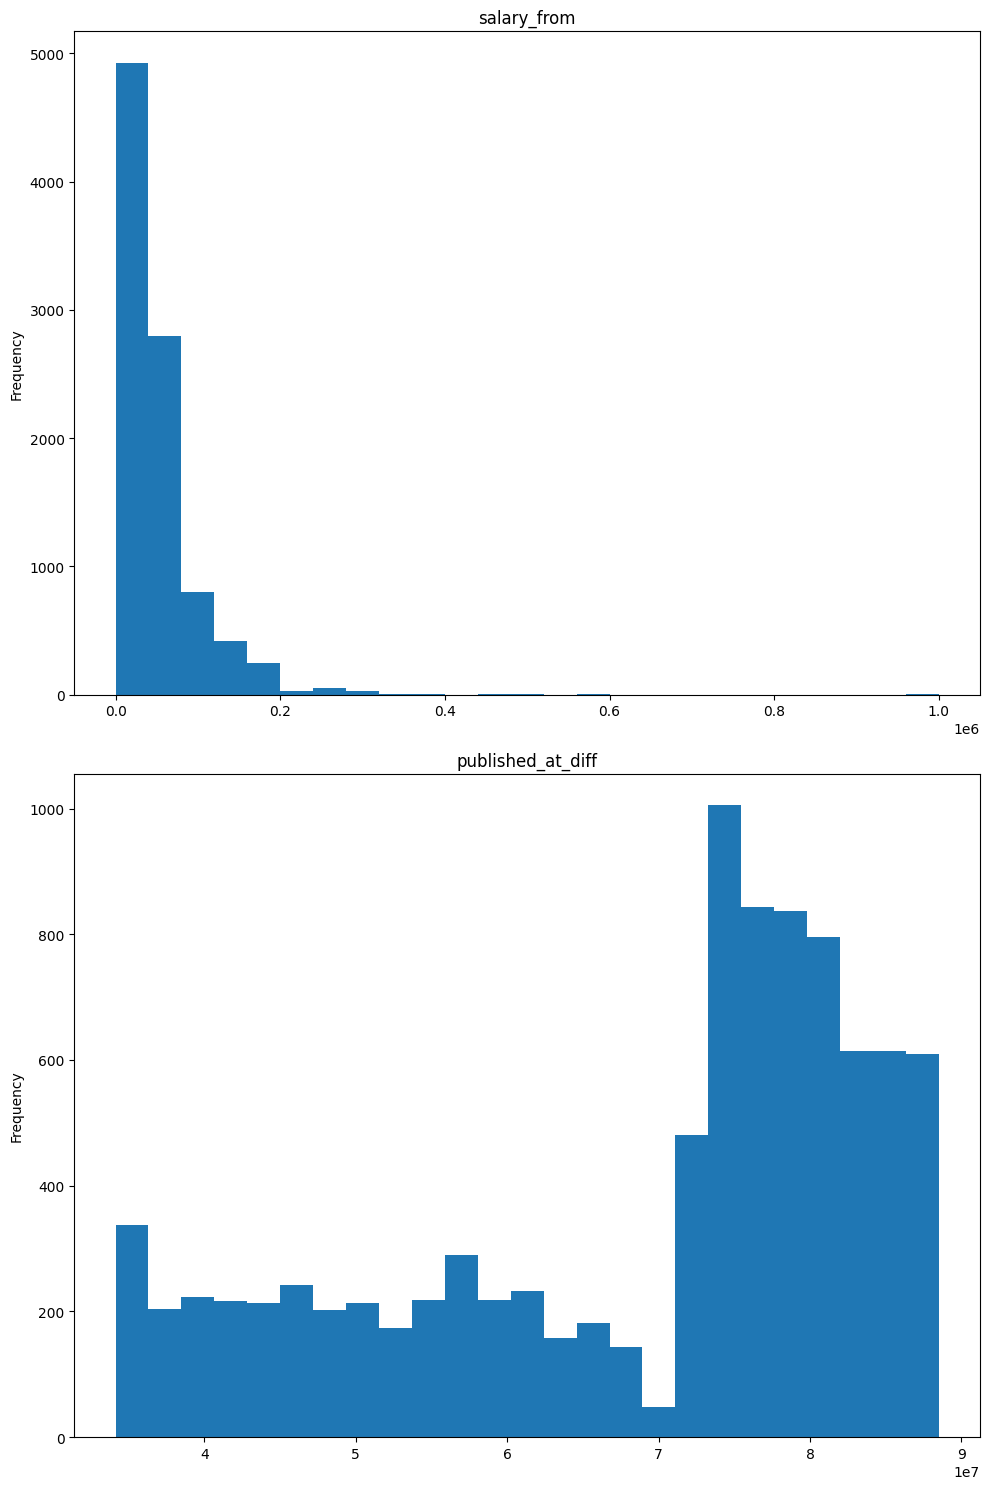

In [203]:
import matplotlib.pyplot as plt
df_numeric1 = df_test[['salary_from', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric1.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric1.columns):
    df_numeric1[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [204]:
df_test["published_at_diff"] = df_test["published_at_diff"] / 1e7
df_test = df_test.drop(columns=['published_at'])

Преобразуем description:

In [205]:
df_test['description'] = pd.Series(df_test['description'],dtype=pd.StringDtype())
df_test.description = df_test.description.apply(lambda x: str(x).lower())

Извлекаем опыт:

In [206]:
df_test['description_exp'] = df_test.description.map(manage_desc_exp)
df_test['description_exp'].value_counts()

description_exp
1.000000     8854
3.000000      215
2.000000      162
5.000000       37
0.500000       21
4.000000        5
6.000000        5
10.000000       5
0.250000        4
0.083333        2
0.333333        1
8.000000        1
Name: count, dtype: int64

In [207]:
df_test.description = df_test.description.apply(lambda x: re.sub(r'<[^>]+>', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>
df_test.description = df_test.description.apply(lambda x: re.sub(r'[^а-яА-Я0-9a-zA-ZёЁ.-]', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

Извлекаем зарплату:

In [208]:
df_test['description_salary'] = df_test.description.map(manage_desc)
df_test['description_salary'].value_counts()

description_salary
40000     112
60000      92
50000      78
30000      74
100000     67
         ... 
135000      1
63450       1
5100        1
6000        1
238000      1
Name: count, Length: 263, dtype: int64

In [209]:
df_test['description_salary'].fillna(df_test.salary_from, inplace = True) 

Подгатавливаем к векторизации:

In [210]:
df_test['description'] = df_test['description'].apply(lambda x: re.sub(r'[^а-яА-Я0-9a-zA-ZёЁ]', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

## remove tabulation and punctuation
df_test['description'] = df_test['description'].map(lambda x: re.sub(r'[^\w\s]', ' ', x)) #str.replace(,' '))
## digits
df_test['description'] = df_test['description'].map(lambda x: re.sub(r'\d+', ' ', x))#.str.replace(, '')


df_test['description'].fillna('nd', inplace = True)

## lemmatization
df_test['description'] = df_test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

Векторизуем:

In [211]:
df_test_desc_parsed = vectorizer.transform(df_test['description'])
df_test_desc_parsed1 = pd.DataFrame(df_test_desc_parsed.toarray(), columns=DESC_COLS, index=df_test.index)
df_test = df_test.join(df_test_desc_parsed1)

In [212]:
df_test = df_test.drop(columns=['description'])

Для area_name, оставим название, если в обучаемом dataset есть столбец, иначе заменяем на Other:

In [213]:
df_test['area_name'] = df_test['area_name'].map(lambda x: x if ('area_name_' + x) in df.columns else "Other")

In [214]:
df_test['area_name'].value_counts()

area_name
Москва             6754
Санкт-Петербург    1877
Other               454
Новосибирск          71
Казань               54
Краснодар            52
Екатеринбург         50
Name: count, dtype: int64

Преобразуем employer_name к нижнему регистру, и сделаем те же преобразования, что и в обучаемом dataset:

In [215]:
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: x.lower())
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: x.strip())

In [216]:
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: "пятёрочка" if near_equal(x, 'пятёрочка') > 0.75 else x)
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: "перекресток" if near_equal(x, 'перекресток') > 0.75 else x)
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: "билайн" if near_equal(x, 'билайн') > 0.75 else x)
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: "personname" if x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') else x) #or x.startswith('ип') or '(ип ' in x)

In [217]:
df_test_empl_parsed = vectorizer_empl.transform(df_test['employer_name'])
df_test_empl_parsed1 = pd.DataFrame(df_test_empl_parsed.toarray(), columns=EMPL_COLS, index=df_test.index)
df_test = df_test.join(df_test_empl_parsed1)

In [218]:
df_test = df_test.drop(columns=['employer_name'])

Ту же процедуру проделываем с name:

In [219]:
df_test['name'] = df_test['name'].apply(lambda x: x.lower())
df_test['name'] = df_test['name'].apply(lambda x: x.strip())

In [220]:
df_test_name_parsed = vectorizer_name.transform(df_test['name'])
df_test_name_parsed1 = pd.DataFrame(df_test_name_parsed.toarray(), columns=NAME_COLS, index=df_test.index)
df_test = df_test.join(df_test_name_parsed1)

In [221]:
df_test = df_test.drop(columns=['name'])

Делаем one-hotting городов:

In [222]:
df_one_hoted_test = df_test.copy()

ONE_HOT_COL_TEST = ['area_name']#,  'published_at_diff'] #'employer_name',

temp_test = pd.get_dummies(df_one_hoted_test[ONE_HOT_COL_TEST], prefix=ONE_HOT_COL_TEST, dtype=bool)

df_one_hoted_test = pd.concat([temp_test, df_test], axis=1)

In [223]:
df_one_hoted_test = df_one_hoted_test.drop(columns=['area_name'])#, 'published_at_diff']) #'employer_name', 

In [224]:
df_test = df_one_hoted_test

Проверим, что все столбцы, которые есть в обучаемом dataset, есть и в тестовом dataset:

In [225]:
for columnName in df_test.columns:
    print(columnName)

area_name_Other
area_name_Екатеринбург
area_name_Казань
area_name_Краснодар
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
has_test
response_letter_required
salary_from
salary_gross
published_at_diff
description_exp
description_salary
desc_api
desc_b
desc_c
desc_ci
desc_crm
desc_cs
desc_d
desc_docker
desc_e
desc_excel
desc_experience
desc_git
desc_google
desc_hr
desc_html
desc_http
desc_j
desc_java
desc_javascript
desc_kpi
desc_linux
desc_m
desc_office
desc_php
desc_postgresql
desc_python
desc_quot
desc_react
desc_rest
desc_ru
desc_sql
desc_team
desc_web
desc_word
desc_work
desc_автоматизации
desc_аккуратность
desc_активно
desc_анализ
desc_анализа
desc_аналитика
desc_английский
desc_английского
desc_архитектуры
desc_базе
desc_базовые
desc_базы
desc_белая
desc_бесплатное
desc_бизнес
desc_бизнеса
desc_больничных
desc_большим
desc_большой
desc_бонусы
desc_быстро
desc_важно
desc_вакансии
desc_вакансию
desc_вакансия
desc_веб
desc_ведение
desc_ведения
desc_вести
desc_взаимо

In [226]:
for columnName in df.columns:
    print(columnName)
    if not (columnName in df_test.columns) and (columnName != 'salary_to'):
        df_test[columnName] = [False] * df_test.shape[0]

area_name_Other
area_name_Екатеринбург
area_name_Казань
area_name_Краснодар
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
has_test
response_letter_required
salary_from
salary_gross
salary_to
published_at_diff
description_exp
description_salary
desc_api
desc_b
desc_c
desc_ci
desc_crm
desc_cs
desc_d
desc_docker
desc_e
desc_excel
desc_experience
desc_git
desc_google
desc_hr
desc_html
desc_http
desc_j
desc_java
desc_javascript
desc_kpi
desc_linux
desc_m
desc_office
desc_php
desc_postgresql
desc_python
desc_quot
desc_react
desc_rest
desc_ru
desc_sql
desc_team
desc_web
desc_word
desc_work
desc_автоматизации
desc_аккуратность
desc_активно
desc_анализ
desc_анализа
desc_аналитика
desc_английский
desc_английского
desc_архитектуры
desc_базе
desc_базовые
desc_базы
desc_белая
desc_бесплатное
desc_бизнес
desc_бизнеса
desc_больничных
desc_большим
desc_большой
desc_бонусы
desc_быстро
desc_важно
desc_вакансии
desc_вакансию
desc_вакансия
desc_веб
desc_ведение
desc_ведения
desc_вести
d

In [227]:
df_test.columns

Index(['area_name_Other', 'area_name_Екатеринбург', 'area_name_Казань',
       'area_name_Краснодар', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'has_test', 'response_letter_required',
       'salary_from',
       ...
       'name_разработчик', 'name_рекрутер', 'name_руководитель',
       'name_руководителя', 'name_специалист', 'name_стажер', 'name_старший',
       'name_уборщица/уборщик', 'name_ул', 'name_юрист'],
      dtype='object', length=626)

In [228]:
df.columns

Index(['area_name_Other', 'area_name_Екатеринбург', 'area_name_Казань',
       'area_name_Краснодар', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'has_test', 'response_letter_required',
       'salary_from',
       ...
       'name_разработчик', 'name_рекрутер', 'name_руководитель',
       'name_руководителя', 'name_специалист', 'name_стажер', 'name_старший',
       'name_уборщица/уборщик', 'name_ул', 'name_юрист'],
      dtype='object', length=627)

Переупорядочиваем столбцы, чтобы соответствовать обучаемой выборке:

In [229]:
columns = df.columns.tolist()
columns.remove('salary_to')
df_test = df_test[columns]

Делаем предсказания:

In [230]:
dtest_reg1 = xgb.DMatrix(df_test)

In [231]:
y_pred_test1_1 = xg_model4.predict(dtest_reg1)
y_pred_test1_2 = xg_model_v2_1.predict(dtest_reg1)
y_pred_test1_3 = cat_model_2.predict(df_test)
y_pred_test1_4 = cat_model2_2.predict(df_test)

Объединяем результаты:

In [232]:
y_pred_test_combo1 = min_k1 / 100 * y_pred_test1_1 + min_k3 / 100 * y_pred_test1_2 + min_k2 / 100 * y_pred_test1_3 + (100 - min_k1 - min_k2 - min_k3) / 100 * y_pred_test1_4

Пишем требуемый результат в файл:

In [233]:
df_test_full = df_test.assign(salary_to = y_pred_test_combo1)

In [234]:
df_output = pd.concat([df_test_full['salary_to']])
df_output

id
20978     52367.065557
3102      38898.483585
14731    301165.140399
16113    234289.071001
8410     138959.728029
             ...      
29490     55443.725674
34298     82264.415255
33921     39161.326878
8886      63653.254149
23978     30073.603127
Name: salary_to, Length: 9312, dtype: float64

In [235]:
from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_output.to_csv(filepath)  